# ABC Inventory Analysis — Revenue & Profit Based

This notebook performs ABC classification on retail SKU-level data using both **revenue** and **profit** as drivers. It includes:

- Data cleaning & quality checks
- SKU-level aggregation
- Revenue-based ABC classification
- Profit-based ABC classification
- Pareto analysis
- Visual exploration
- Business insights & recommendations

In [81]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

## 1. Data Loading & Cleaning
This section loads the Superstore dataset and prepares SKU-level data for analysis.

In [82]:
from pathlib import Path
list(Path('../data/raw').glob('*'))

[PosixPath('../data/raw/Sample - Superstore.csv')]

In [83]:
df = pd.read_csv(csv_path, encoding='latin1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [84]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [85]:
print("Variable 'df' exists:", 'df' in globals())
print("Rows, columns:", df.shape)
print("Column names:")
print(list(df.columns))

Variable 'df' exists: True
Rows, columns: (9994, 21)
Column names:
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


In [86]:
df_clean = df.copy()
df_clean.shape

(9994, 21)

In [87]:
# Renaming columns to a useable format
rename_map = {
    'Product ID': 'sku',
    'Quantity': 'units_sold',
    'Sales': 'sales_total',
    'Category': 'category'
}

In [88]:
# renaming only if the keys exist to avoid errors
existing_renames = {k:v for k,v in rename_map.items() if k in df_clean.columns}
df_clean = df_clean.rename(columns=existing_renames)

In [89]:
# show the new column list and first 3 rows of relevant columns
print(list(df_clean.columns))
df_clean[['sku','units_sold','sales_total','category']].head(3)

['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'sku', 'category', 'Sub-Category', 'Product Name', 'sales_total', 'units_sold', 'Discount', 'Profit']


,sku,units_sold,sales_total,category
0,FUR-BO-10001798,2,261.96,Furniture
1,FUR-CH-10000454,3,731.94,Furniture
2,OFF-LA-10000240,2,14.62,Office Supplies


In [90]:
# making numeric, handle errors, and show basic stats
df_clean['units_sold'] = pd.to_numeric(df_clean['units_sold'], errors='coerce').fillna(0).astype(int)
df_clean['sales_total'] = pd.to_numeric(df_clean['sales_total'], errors='coerce').fillna(0.0).astype(float)

print("Units sold stats:")
print(df_clean['units_sold'].describe())
print("\nSales total stats:")
print(df_clean['sales_total'].describe())

Units sold stats:
count    9994.000000
mean        3.789574
std         2.225110
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        14.000000
Name: units_sold, dtype: float64

Sales total stats:
count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: sales_total, dtype: float64


In [91]:
bad = df_clean[df_clean['sales_total'] <= 0]
print(f"\nRows with sales_total <= 0 : {len(bad)} (we'll ignore or handle later).")


Rows with sales_total <= 0 : 0 (we'll ignore or handle later).


In [92]:
# Computing unit_price at the row level
df_clean['unit_price'] = df_clean.apply(
    lambda r: (r['sales_total'] / r['units_sold']) if r['units_sold'] > 0 else np.nan,
    axis=1
)

# show a few examples including any NaNs
display(df_clean[['sku','units_sold','sales_total','unit_price']].head(6))
print("Count of NaN unit_price (due to zero qty):", df_clean['unit_price'].isna().sum())

,sku,units_sold,sales_total,unit_price
0,FUR-BO-10001798,2,261.9600,130.9800
1,FUR-CH-10000454,3,731.9400,243.9800
2,OFF-LA-10000240,2,14.6200,7.3100
3,FUR-TA-10000577,5,957.5775,191.5155
4,OFF-ST-10000760,2,22.3680,11.1840
5,FUR-FU-10001487,7,48.8600,6.9800


Count of NaN unit_price (due to zero qty): 0


## 2. Revenue-Based ABC Classification
We calculate total revenue per SKU, derive cumulative contribution, and assign ABC classes.

In [93]:
# aggregate per SKU
sku_agg = df_clean.groupby(['sku','category'], as_index=False).agg({
    'units_sold': 'sum',
    'sales_total': 'sum'
})

# computing a SKU-level unit price (weighted), and total_value (same as sales_total)
sku_agg['unit_price'] = sku_agg.apply(
    lambda r: (r['sales_total'] / r['units_sold']) if r['units_sold'] > 0 else 0,
    axis=1
)
sku_agg['total_value'] = sku_agg['sales_total']   

sku_agg[['sku','category','units_sold','unit_price','total_value']].head(8)


,sku,category,units_sold,unit_price,total_value
0,FUR-BO-10000112,Furniture,9,91.686000,825.1740
1,FUR-BO-10000330,Furniture,10,106.462400,1064.6240
2,FUR-BO-10000362,Furniture,14,153.882000,2154.3480
3,FUR-BO-10000468,Furniture,21,34.468667,723.8420
4,FUR-BO-10000711,Furniture,12,70.980000,851.7600
5,FUR-BO-10000780,Furniture,22,133.925764,2946.3668
6,FUR-BO-10001337,Furniture,28,106.073536,2970.0590
7,FUR-BO-10001519,Furniture,22,50.872500,1119.1950


In [15]:
# SKU-level summaries
print("Total unique SKUs:", sku_agg['sku'].nunique())
print("Sum of total_value (should match sum of sales_total):", sku_agg['total_value'].sum(), 
      " original sales sum:", df_clean['sales_total'].sum())

# Top 10 SKUs
sku_agg.sort_values('total_value', ascending=False).head(10)


Total unique SKUs: 1862
Sum of total_value (should match sum of sales_total): 2297200.8603000003  original sales sum: 2297200.8603000003


,sku,category,units_sold,sales_total,unit_price,total_value
1614,TEC-CO-10004722,Technology,20,61599.824,3079.991200,61599.824
776,OFF-BI-10003527,Office Supplies,31,27453.384,885.593032,27453.384
1642,TEC-MA-10002412,Technology,6,22638.480,3773.080000,22638.480
80,FUR-CH-10002024,Furniture,39,21870.576,560.784000,21870.576
691,OFF-BI-10001359,Office Supplies,37,19823.479,535.769703,19823.479
657,OFF-BI-10000545,Office Supplies,48,19024.500,396.343750,19024.500
1604,TEC-CO-10001449,Technology,38,18839.686,495.781211,18839.686
1631,TEC-MA-10001127,Technology,12,18374.895,1531.241250,18374.895
845,OFF-BI-10004995,Office Supplies,27,17965.068,665.372889,17965.068
1420,OFF-SU-10000151,Office Supplies,11,17030.312,1548.210182,17030.312


In [94]:
# Sorting SKUs by total_value (highest to lowest)
sku_sorted = sku_agg.sort_values('total_value', ascending=False).reset_index(drop=True)

sku_sorted.head(10)

,sku,category,units_sold,sales_total,unit_price,total_value
0,TEC-CO-10004722,Technology,20,61599.824,3079.991200,61599.824
1,OFF-BI-10003527,Office Supplies,31,27453.384,885.593032,27453.384
2,TEC-MA-10002412,Technology,6,22638.480,3773.080000,22638.480
3,FUR-CH-10002024,Furniture,39,21870.576,560.784000,21870.576
4,OFF-BI-10001359,Office Supplies,37,19823.479,535.769703,19823.479
5,OFF-BI-10000545,Office Supplies,48,19024.500,396.343750,19024.500
6,TEC-CO-10001449,Technology,38,18839.686,495.781211,18839.686
7,TEC-MA-10001127,Technology,12,18374.895,1531.241250,18374.895
8,OFF-BI-10004995,Office Supplies,27,17965.068,665.372889,17965.068
9,OFF-SU-10000151,Office Supplies,11,17030.312,1548.210182,17030.312


In [95]:
# percent contribution per SKU (of total sales value)
total_revenue = sku_sorted['total_value'].sum()
sku_sorted['value_pct'] = sku_sorted['total_value'] / total_revenue * 100

# show top 10 with the new column
sku_sorted[['sku','category','units_sold','total_value','value_pct']].head(10)

,sku,category,units_sold,total_value,value_pct
0,TEC-CO-10004722,Technology,20,61599.824,2.681517
1,OFF-BI-10003527,Office Supplies,31,27453.384,1.195080
2,TEC-MA-10002412,Technology,6,22638.480,0.985481
3,FUR-CH-10002024,Furniture,39,21870.576,0.952053
4,OFF-BI-10001359,Office Supplies,37,19823.479,0.862941
5,OFF-BI-10000545,Office Supplies,48,19024.500,0.828160
6,TEC-CO-10001449,Technology,38,18839.686,0.820115
7,TEC-MA-10001127,Technology,12,18374.895,0.799882
8,OFF-BI-10004995,Office Supplies,27,17965.068,0.782042
9,OFF-SU-10000151,Office Supplies,11,17030.312,0.741351


In [96]:
# Cumulative percentage
sku_sorted['cum_value_pct'] = sku_sorted['value_pct'].cumsum()

# show first 15 to inspect the accumulation
sku_sorted[['sku','category','total_value','value_pct','cum_value_pct']].head(15)

,sku,category,total_value,value_pct,cum_value_pct
0,TEC-CO-10004722,Technology,61599.8240,2.681517,2.681517
1,OFF-BI-10003527,Office Supplies,27453.3840,1.195080,3.876596
2,TEC-MA-10002412,Technology,22638.4800,0.985481,4.862078
3,FUR-CH-10002024,Furniture,21870.5760,0.952053,5.814131
4,OFF-BI-10001359,Office Supplies,19823.4790,0.862941,6.677071
5,OFF-BI-10000545,Office Supplies,19024.5000,0.828160,7.505232
6,TEC-CO-10001449,Technology,18839.6860,0.820115,8.325346
7,TEC-MA-10001127,Technology,18374.8950,0.799882,9.125228
8,OFF-BI-10004995,Office Supplies,17965.0680,0.782042,9.907270
9,OFF-SU-10000151,Office Supplies,17030.3120,0.741351,10.648621


In [97]:
# Assigning ABC class based on cumulative percentage thresholds
def assign_abc(cum_pct):
    if cum_pct <= 70:
        return 'A'
    elif cum_pct <= 90:
        return 'B'
    else:
        return 'C'

sku_sorted['ABC_class'] = sku_sorted['cum_value_pct'].apply(assign_abc)

# show counts and top rows by class
sku_sorted[['sku','total_value','value_pct','cum_value_pct','ABC_class']].head(15)

,sku,total_value,value_pct,cum_value_pct,ABC_class
0,TEC-CO-10004722,61599.8240,2.681517,2.681517,A
1,OFF-BI-10003527,27453.3840,1.195080,3.876596,A
2,TEC-MA-10002412,22638.4800,0.985481,4.862078,A
3,FUR-CH-10002024,21870.5760,0.952053,5.814131,A
4,OFF-BI-10001359,19823.4790,0.862941,6.677071,A
5,OFF-BI-10000545,19024.5000,0.828160,7.505232,A
6,TEC-CO-10001449,18839.6860,0.820115,8.325346,A
7,TEC-MA-10001127,18374.8950,0.799882,9.125228,A
8,OFF-BI-10004995,17965.0680,0.782042,9.907270,A
9,OFF-SU-10000151,17030.3120,0.741351,10.648621,A


In [98]:
# Classwise summary
counts = sku_sorted['ABC_class'].value_counts().reindex(['A','B','C']).fillna(0).astype(int)
value_by_class = sku_sorted.groupby('ABC_class')['total_value'].sum().reindex(['A','B','C']).fillna(0)

summary_df = pd.DataFrame({
    'count': counts,
    'value_sum': value_by_class,
})
summary_df['pct_of_skus'] = summary_df['count'] / summary_df['count'].sum() * 100
summary_df['pct_of_value'] = summary_df['value_sum'] / total_revenue * 100

summary_df

,count,value_sum,pct_of_skus,pct_of_value
ABC_class,,,,
A,280,1.606932e+06,15.037594,69.951723
B,373,4.601024e+05,20.032223,20.028827
C,1209,2.301669e+05,64.930183,10.019450


In [99]:
# saving final SKU-level file with ABC labels
out_path = Path('../data/processed/sku_abc_with_labels.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)
sku_sorted.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: ../data/processed/sku_abc_with_labels.csv


### Revenue Pareto Chart
This chart shows how a small subset of SKUs contributes to most revenue.

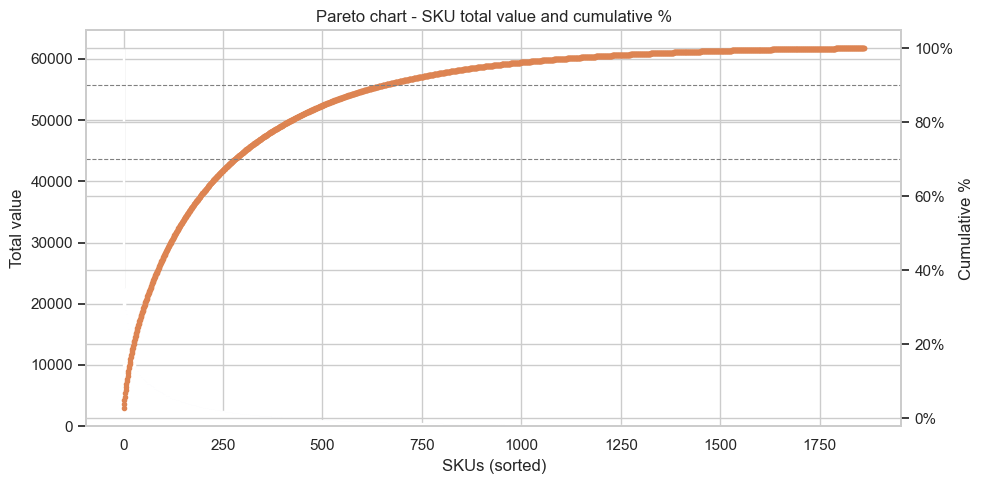

In [100]:
# Chart
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(len(sku_sorted)), sku_sorted['total_value'], label='SKU value')
ax.set_xlabel('SKUs (sorted)')
ax.set_ylabel('Total value')

ax2 = ax.twinx()
ax2.plot(sku_sorted['cum_value_pct'], color='C1', marker='.', linewidth=1, label='Cumulative %')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.axhline(70, color='gray', linestyle='--', linewidth=0.8)
ax2.axhline(90, color='gray', linestyle='--', linewidth=0.8)
ax2.set_ylabel('Cumulative %')

ax.set_title('Pareto chart - SKU total value and cumulative %')
plt.tight_layout()
plt.show()

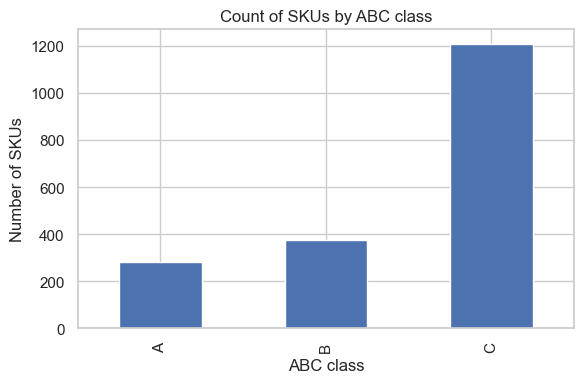

Saved: ../outputs/figures/abc_counts.png


In [101]:
# bar chart
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
sku_sorted['ABC_class'].value_counts().reindex(['A','B','C']).plot(kind='bar', ax=ax)
ax.set_title('Count of SKUs by ABC class')
ax.set_xlabel('ABC class')
ax.set_ylabel('Number of SKUs')
plt.tight_layout()
out = Path('../outputs/figures/abc_counts.png')
out.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out, dpi=150)
plt.show()
print("Saved:", out)

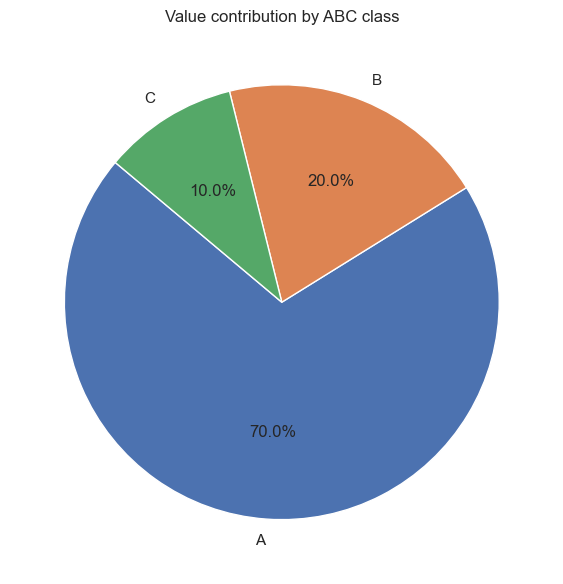

Saved: ../outputs/figures/value_share_pie.png


In [102]:
# pie chart 
value_by_class = sku_sorted.groupby('ABC_class')['total_value'].sum().reindex(['A','B','C'])
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(value_by_class, labels=value_by_class.index, autopct='%1.1f%%', startangle=140)
ax.set_title('Value contribution by ABC class')
plt.tight_layout()
out = Path('../outputs/figures/value_share_pie.png')
plt.savefig(out, dpi=150)
plt.show()
print("Saved:", out)

In [26]:
# Create a short insights.md using your computed numbers
total_revenue = total_revenue  # already computed earlier
count_A = summary_df.loc['A','count']
count_B = summary_df.loc['B','count']
count_C = summary_df.loc['C','count']
pct_A = summary_df.loc['A','pct_of_value']
pct_B = summary_df.loc['B','pct_of_value']
pct_C = summary_df.loc['C','pct_of_value']
n_skus = sku_sorted['sku'].nunique()

insights = f"""# ABC Inventory Classification — Insights

**Total SKUs analyzed:** {n_skus}
**Total revenue (period):** {total_revenue:,.2f}

## Class breakdown
- **A items:** {count_A} SKUs ({summary_df.loc['A','pct_of_skus']:.1f}% of SKUs) — contribute {pct_A:.1f}% of total revenue.
- **B items:** {count_B} SKUs ({summary_df.loc['B','pct_of_skus']:.1f}% of SKUs) — contribute {pct_B:.1f}% of total revenue.
- **C items:** {count_C} SKUs ({summary_df.loc['C','pct_of_skus']:.1f}% of SKUs) — contribute {pct_C:.1f}% of total revenue.

## Key observations
- A small subset of SKUs (A) account for the majority of revenue; prioritize forecasting, supplier SLAs, and faster replenishment for these items.
- B items have moderate importance; balance inventory levels and ordering frequency.
- C items represent the long tail; consider lower safety stock, lower review frequency, or delisting slow movers.

## Next steps / improvements
- Consider ABC by profit margin instead of revenue.
- Add lead time and demand variability to compute safety stock quantitatively.
- Re-run classification periodically (monthly or quarterly) and flag items that change classes.
"""

out = Path('../outputs/reports/insights.md')
out.parent.mkdir(parents=True, exist_ok=True)
out.write_text(insights)
print("Saved insights to", out)


Saved insights to ../outputs/reports/insights.md


## 3. Profit-Based ABC Classification
A second ABC analysis based on SKU-level profit contribution.

In [115]:
# Step 0: for profit ABC Analysis
try:
    print("df_clean found. Row count:", len(df_clean))
    print("Columns:", list(df_clean.columns))
except NameError:
    raise NameError("df_clean not found. Run the earlier cleaning/Load cell first.")


df_clean found. Row count: 9994
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'sku', 'category', 'Sub-Category', 'Product Name', 'sales_total', 'units_sold', 'Discount', 'Profit', 'unit_price']


In [44]:
# Step 1: check required columns
required = {'SKU', 'category', 'units_sold', 'sales_total', 'Profit'}
present = set(df_clean.columns)
missing = required - present
print("Missing columns:", missing)
if missing:
    # show likely candidate columns to help you rename
    candidates = {c for c in df_clean.columns if c.lower() in {'sku','category','units','units_sold','sales','sales_total','profit'}}
    print("Possible candidate columns you might rename from:", candidates)

Missing columns: {'SKU'}
Possible candidate columns you might rename from: {'sku', 'sales_total', 'category', 'Profit', 'units_sold'}


In [48]:
# Step 2: aggregate
profit_agg = df_clean.groupby(['sku','category'], as_index=False).agg({
    'units_sold':'sum',
    'sales_total':'sum',
    'Profit':'sum'
})
profit_agg = profit_agg.rename(columns={'Profit':'profit_sum', 'sales_total':'sales_sum'})
print("rows in profit_agg:", len(profit_agg))
profit_agg.head(5)

rows in profit_agg: 1862


,sku,category,units_sold,sales_sum,profit_sum
0,FUR-BO-10000112,Furniture,9,825.174,-117.8820
1,FUR-BO-10000330,Furniture,10,1064.624,24.1960
2,FUR-BO-10000362,Furniture,14,2154.348,311.1836
3,FUR-BO-10000468,Furniture,21,723.842,-133.1092
4,FUR-BO-10000711,Furniture,12,851.760,229.9752


In [49]:
# Step 3: profit pct
total_profit = profit_agg['profit_sum'].sum()
print("total_profit:", total_profit)
profit_agg['profit_pct'] = profit_agg['profit_sum'] / total_profit * 100
profit_agg[['sku','profit_sum','profit_pct']].head(8)

total_profit: 286397.02170000004


,sku,profit_sum,profit_pct
0,FUR-BO-10000112,-117.8820,-0.041160
1,FUR-BO-10000330,24.1960,0.008448
2,FUR-BO-10000362,311.1836,0.108655
3,FUR-BO-10000468,-133.1092,-0.046477
4,FUR-BO-10000711,229.9752,0.080299
5,FUR-BO-10000780,-767.7436,-0.268070
6,FUR-BO-10001337,-78.6370,-0.027457
7,FUR-BO-10001519,147.0942,0.051360


In [50]:
# Step 4: sort & cumulative %
profit_agg = profit_agg.sort_values('profit_sum', ascending=False).reset_index(drop=True)
profit_agg['cum_profit_pct'] = profit_agg['profit_pct'].cumsum()
profit_agg[['sku','profit_sum','profit_pct','cum_profit_pct']].head(12)

,sku,profit_sum,profit_pct,cum_profit_pct
0,TEC-CO-10004722,25199.9280,8.798949,8.798949
1,OFF-BI-10003527,7753.0390,2.707095,11.506044
2,TEC-CO-10001449,6983.8836,2.438532,13.944576
3,TEC-CO-10003763,4570.9347,1.596013,15.540589
4,TEC-AC-10002049,4425.3432,1.545178,17.085767
5,TEC-MA-10001127,4094.9766,1.429825,18.515592
6,TEC-MA-10003979,3772.9461,1.317383,19.832976
7,TEC-MA-10001047,3717.9714,1.298188,21.131163
8,OFF-BI-10001120,3345.2823,1.168058,22.299221
9,TEC-MA-10000045,3343.5360,1.167448,23.466669


In [51]:
# Step 5: assign ABC
profit_agg['ABC_profit'] = profit_agg['cum_profit_pct'].apply(lambda x: 'A' if x <= 70 else ('B' if x <= 90 else 'C'))
profit_agg[['sku','profit_sum','cum_profit_pct','ABC_profit']].head(12)
print("ABC counts:\n", profit_agg['ABC_profit'].value_counts())

ABC counts:
 ABC_profit
C    1634
A     114
B     114
Name: count, dtype: int64


In [53]:
from pathlib import Path

out_path = Path("../data/processed/sku_abc_by_profit.csv")

# Create the folder if needed
out_path.parent.mkdir(parents=True, exist_ok=True)

profit_agg.to_csv(out_path, index=False)

print("Saved →", out_path.resolve())

Saved → /Users/joel/Documents/Projects for fun/abc-inventory-project/data/processed/sku_abc_by_profit.csv


In [54]:
from pathlib import Path

fig_dir = Path("../outputs/figures")
fig_dir.mkdir(parents=True, exist_ok=True)
print("Figures will be saved to:", fig_dir.resolve())

Figures will be saved to: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/figures


### Profit Pareto Chart
This chart visualizes which SKUs contribute the most to total profit.


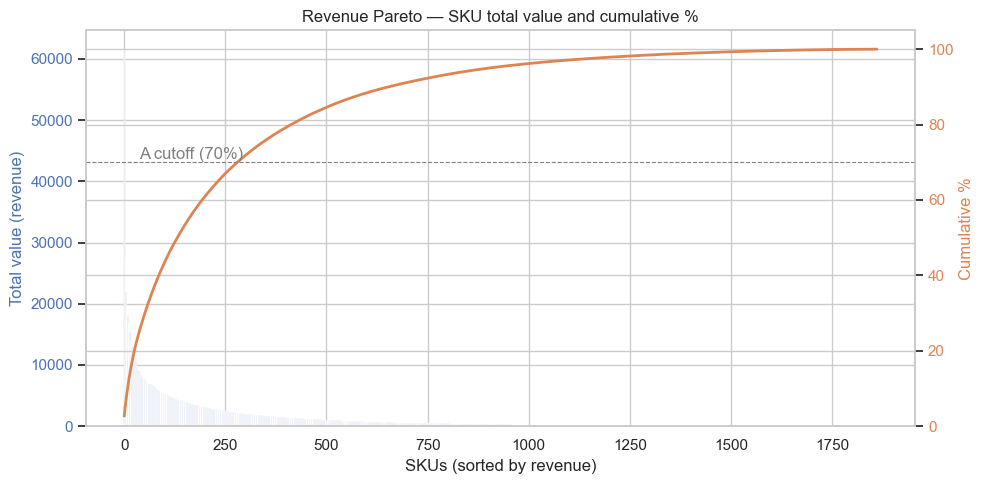

Saved: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/figures/pareto_revenue.png


In [55]:
import matplotlib.pyplot as plt
import numpy as np

# uses sku_sorted (must exist)
x = np.arange(len(sku_sorted))
y = sku_sorted['total_value'].values
cum_pct = sku_sorted['cum_value_pct'].values

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(x, y, color='C0', alpha=0.7)
ax1.set_xlabel('SKUs (sorted by revenue)')
ax1.set_ylabel('Total value (revenue)', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(x, cum_pct, color='C1', linewidth=2)
ax2.set_ylabel('Cumulative %', color='C1')
ax2.set_ylim(0, 105)
ax2.tick_params(axis='y', labelcolor='C1')

# mark 70% line
ax2.axhline(70, color='gray', linestyle='--', linewidth=0.8)
ax2.text(len(x)*0.02, 70+1, 'A cutoff (70%)', color='gray')

plt.title('Revenue Pareto — SKU total value and cumulative %')
plt.tight_layout()
out = fig_dir / "pareto_revenue.png"
fig.savefig(out, dpi=150)
plt.show()
print("Saved:", out.resolve())

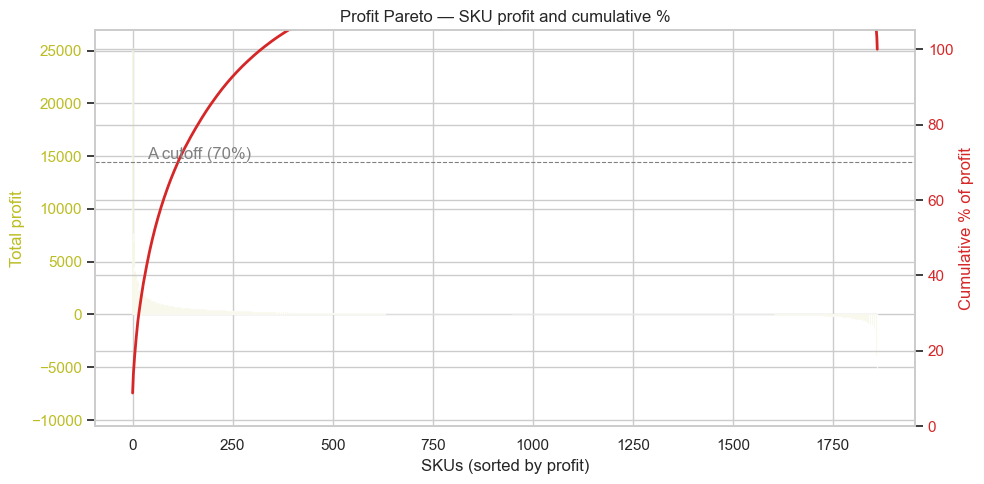

Saved: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/figures/pareto_profit.png


In [56]:
import matplotlib.pyplot as plt
import numpy as np

# uses profit_agg (must exist) sorted by profit_sum descending and cum_profit_pct
x = np.arange(len(profit_agg))
y = profit_agg['profit_sum'].values
cum_pct = profit_agg['cum_profit_pct'].values

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(x, y, color='tab:olive', alpha=0.7)
ax1.set_xlabel('SKUs (sorted by profit)')
ax1.set_ylabel('Total profit', color='tab:olive')
ax1.tick_params(axis='y', labelcolor='tab:olive')

ax2 = ax1.twinx()
ax2.plot(x, cum_pct, color='tab:red', linewidth=2)
ax2.set_ylabel('Cumulative % of profit', color='tab:red')
ax2.set_ylim(0, 105)
ax2.tick_params(axis='y', labelcolor='tab:red')

ax2.axhline(70, color='gray', linestyle='--', linewidth=0.8)
ax2.text(len(x)*0.02, 70+1, 'A cutoff (70%)', color='gray')

plt.title('Profit Pareto — SKU profit and cumulative %')
plt.tight_layout()
out = fig_dir / "pareto_profit.png"
fig.savefig(out, dpi=150)
plt.show()
print("Saved:", out.resolve())

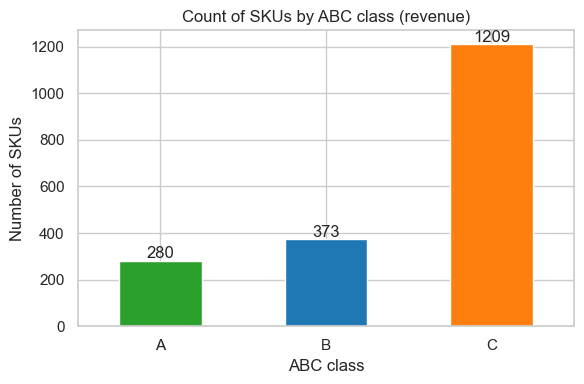

Saved: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/figures/abc_counts_revenue.png


In [57]:
import matplotlib.pyplot as plt

counts = sku_sorted['ABC_class'].value_counts().reindex(['A','B','C']).fillna(0)
fig, ax = plt.subplots(figsize=(6,4))
counts.plot(kind='bar', ax=ax, rot=0, color=['#2ca02c','#1f77b4','#ff7f0e'])
ax.set_title('Count of SKUs by ABC class (revenue)')
ax.set_xlabel('ABC class')
ax.set_ylabel('Number of SKUs')
for i, v in enumerate(counts):
    ax.text(i, v + max(counts)*0.01, str(int(v)), ha='center')
plt.tight_layout()
out = fig_dir / "abc_counts_revenue.png"
fig.savefig(out, dpi=150)
plt.show()
print("Saved:", out.resolve())

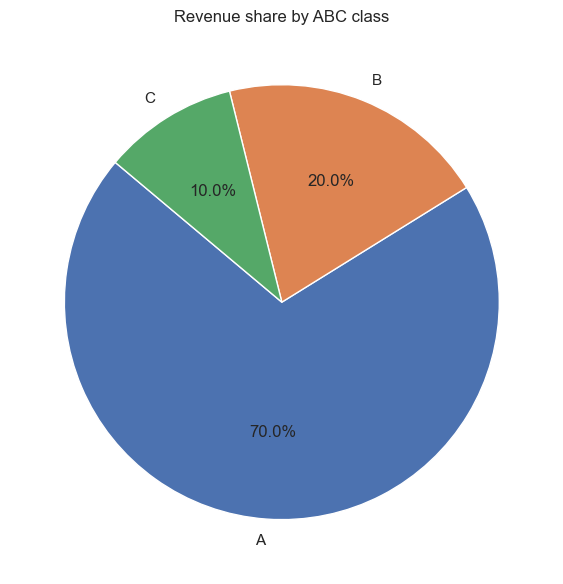

Saved: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/figures/abc_value_share_revenue_pie.png


In [58]:
fig, ax = plt.subplots(figsize=(6,6))
vals = sku_sorted.groupby('ABC_class')['total_value'].sum().reindex(['A','B','C']).fillna(0)
labels = ['A','B','C']
ax.pie(vals, labels=labels, autopct='%1.1f%%', startangle=140)
ax.set_title('Revenue share by ABC class')
plt.tight_layout()
out = fig_dir / "abc_value_share_revenue_pie.png"
fig.savefig(out, dpi=150)
plt.show()
print("Saved:", out.resolve())

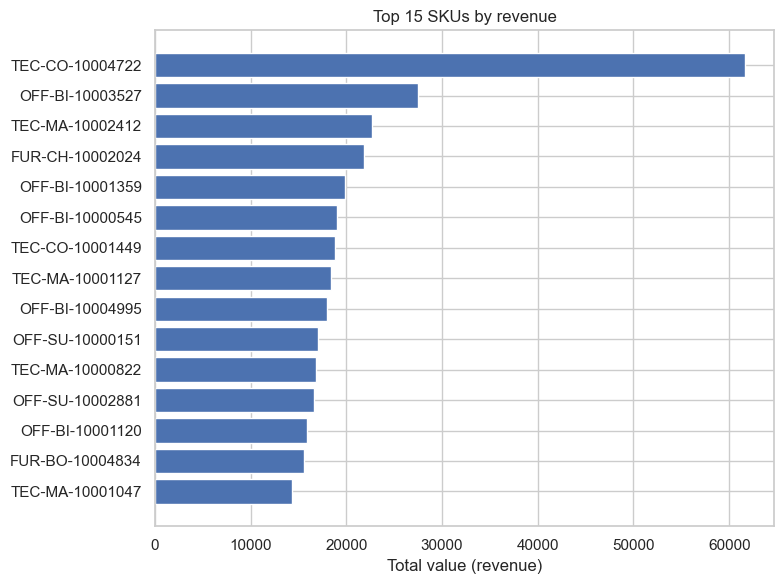

Saved: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/figures/top_15_skus_revenue.png


In [59]:
top_n = 15
top_rev = sku_sorted.head(top_n).copy()
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top_rev['sku'][::-1], top_rev['total_value'][::-1])
ax.set_xlabel('Total value (revenue)')
ax.set_title(f'Top {top_n} SKUs by revenue')
plt.tight_layout()
out = fig_dir / f"top_{top_n}_skus_revenue.png"
fig.savefig(out, dpi=150)
plt.show()
print("Saved:", out.resolve())

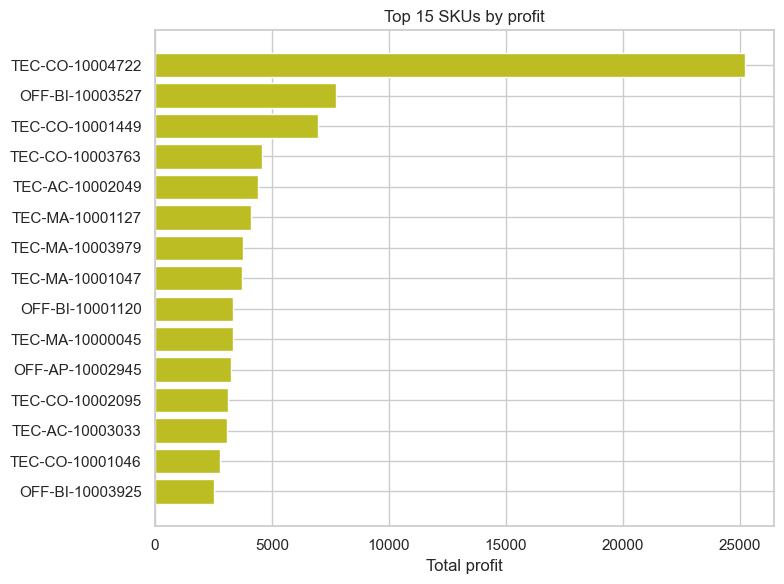

Saved: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/figures/top_15_skus_profit.png


In [60]:
top_n = 15
top_profit = profit_agg.head(top_n).copy()
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top_profit['sku'][::-1], top_profit['profit_sum'][::-1], color='tab:olive')
ax.set_xlabel('Total profit')
ax.set_title(f'Top {top_n} SKUs by profit')
plt.tight_layout()
out = fig_dir / f"top_{top_n}_skus_profit.png"
fig.savefig(out, dpi=150)
plt.show()
print("Saved:", out.resolve())

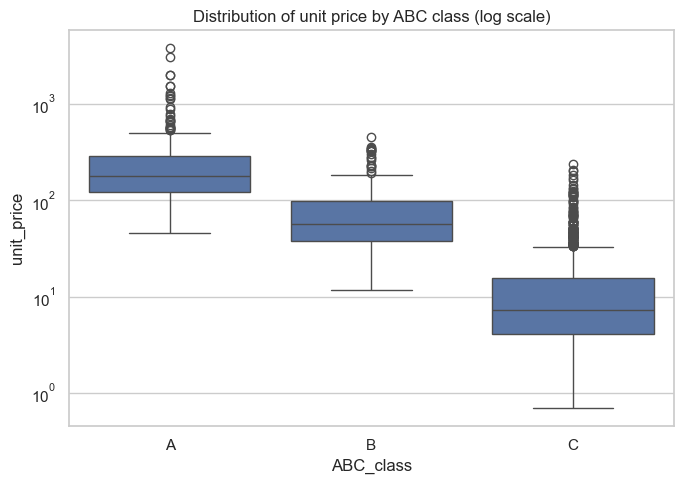

Saved: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/figures/unit_price_boxplot_by_abc.png


In [61]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(7,5))
# ensure sku_sorted has unit_price; if not, compute approx from sales_total/units_sold
if 'unit_price' not in sku_sorted.columns:
    sku_sorted['unit_price'] = sku_sorted['sales_total'] / sku_sorted['units_sold'].replace(0, np.nan)
sns.boxplot(x='ABC_class', y='unit_price', data=sku_sorted, order=['A','B','C'], ax=ax)
ax.set_yscale('log')  # log scale helps if prices vary widely
ax.set_title('Distribution of unit price by ABC class (log scale)')
plt.tight_layout()
out = fig_dir / "unit_price_boxplot_by_abc.png"
fig.savefig(out, dpi=150)
plt.show()
print("Saved:", out.resolve())

<Figure size 1000x600 with 0 Axes>

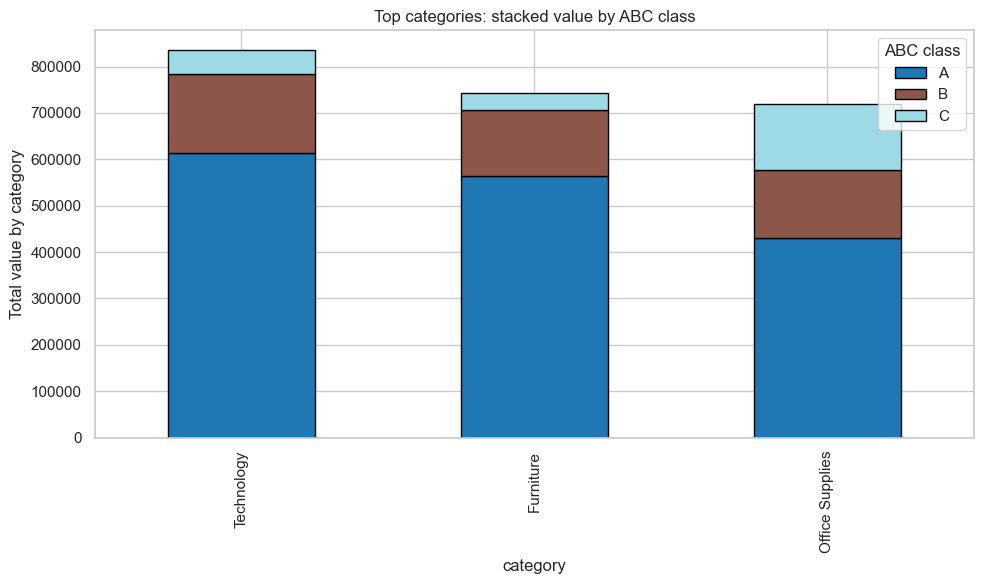

Saved: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/figures/category_stacked_by_abc_value.png


In [62]:
# group and pivot: sum total_value by ABC_class and category, then normalize by total_value
cat_by_abc = sku_sorted.groupby(['category','ABC_class'])['total_value'].sum().unstack(fill_value=0).reindex(columns=['A','B','C']).fillna(0)
# take top categories by total value
cat_total = cat_by_abc.sum(axis=1).sort_values(ascending=False)
top_cats = cat_total.head(8).index
cat_plot = cat_by_abc.loc[top_cats]

fig = plt.figure(figsize=(10,6))
ax = cat_plot.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20', edgecolor='black')
ax.set_ylabel('Total value by category')
ax.set_title('Top categories: stacked value by ABC class')
plt.legend(title='ABC class')
plt.tight_layout()
out = fig_dir / "category_stacked_by_abc_value.png"
fig.savefig(out, dpi=150)
plt.show()
print("Saved:", out.resolve())

In [63]:
from pathlib import Path

# Ensure both key tables exist
try:
    sku_revenue_abc = sku_sorted.copy()
    sku_profit_abc = profit_agg.copy()
except NameError:
    raise NameError("Run the revenue ABC and profit ABC analysis first.")

# Keep only needed columns from each table
rev_cols = ['sku', 'category', 'total_value', 'value_pct', 'cum_value_pct', 'ABC_class']
profit_cols = ['sku', 'profit_sum', 'profit_pct', 'cum_profit_pct', 'ABC_profit']

sku_rev_clean = sku_revenue_abc[rev_cols]
sku_prof_clean = sku_profit_abc[profit_cols]

# Merge on SKU
sku_final = sku_rev_clean.merge(
    sku_prof_clean,
    on='sku',
    how='left'
)

print("Final merged table shape:", sku_final.shape)
sku_final.head(10)

Final merged table shape: (1862, 10)


,sku,category,total_value,value_pct,cum_value_pct,ABC_class,profit_sum,profit_pct,cum_profit_pct,ABC_profit
0,TEC-CO-10004722,Technology,61599.824,2.681517,2.681517,A,2.519993e+04,8.798949e+00,8.798949,A
1,OFF-BI-10003527,Office Supplies,27453.384,1.195080,3.876596,A,7.753039e+03,2.707095e+00,11.506044,A
2,TEC-MA-10002412,Technology,22638.480,0.985481,4.862078,A,-1.811078e+03,-6.323664e-01,108.379491,C
3,FUR-CH-10002024,Furniture,21870.576,0.952053,5.814131,A,5.684342e-14,1.984777e-17,126.788383,C
4,OFF-BI-10001359,Office Supplies,19823.479,0.862941,6.677071,A,2.233505e+03,7.798632e-01,30.998444,A
5,OFF-BI-10000545,Office Supplies,19024.500,0.828160,7.505232,A,7.609800e+02,2.657081e-01,66.174309,A
6,TEC-CO-10001449,Technology,18839.686,0.820115,8.325346,A,6.983884e+03,2.438532e+00,13.944576,A
7,TEC-MA-10001127,Technology,18374.895,0.799882,9.125228,A,4.094977e+03,1.429825e+00,18.515592,A
8,OFF-BI-10004995,Office Supplies,17965.068,0.782042,9.907270,A,-1.878166e+03,-6.557911e-01,107.723700,C
9,OFF-SU-10000151,Office Supplies,17030.312,0.741351,10.648621,A,-2.620048e+02,-9.148307e-02,121.658768,C


In [64]:
from pathlib import Path

# Create folder
out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

# Get additional fields from your original aggregated tables
# NOTE: sku_agg contains units_sold and sales_total
sku_base = sku_agg[['sku', 'units_sold', 'sales_total']].copy()

# Combine the data
sku_master = sku_base.merge(
    sku_final,
    on='sku',
    how='left'
)

# Reorder columns nicely
sku_master = sku_master[
    [
        'sku',
        'category',
        'units_sold',
        'sales_total',
        'total_value',        # revenue
        'value_pct',          # revenue %
        'cum_value_pct',      # cumulative %
        'ABC_class',          # revenue ABC

        'profit_sum',         # profit
        'profit_pct',         # profit %
        'cum_profit_pct',     # cumulative profit %
        'ABC_profit',         # profit ABC
    ]
]

# Save master file
master_path = out_dir / "sku_master_summary.csv"
sku_master.to_csv(master_path, index=False)

print("Saved master summary CSV →", master_path.resolve())
sku_master.head(10)

Saved master summary CSV → /Users/joel/Documents/Projects for fun/abc-inventory-project/data/processed/sku_master_summary.csv


,sku,category,units_sold,sales_total,total_value,value_pct,cum_value_pct,ABC_class,profit_sum,profit_pct,cum_profit_pct,ABC_profit
0,FUR-BO-10000112,Furniture,9,825.1740,825.1740,0.035921,87.466431,B,-117.8820,-0.041160,124.845293,C
1,FUR-BO-10000330,Furniture,10,1064.6240,1064.6240,0.046344,84.582455,B,24.1960,0.008448,125.021596,C
2,FUR-BO-10000362,Furniture,14,2154.3480,2154.3480,0.093781,70.610827,B,311.1836,0.108655,95.140215,C
3,FUR-BO-10000468,Furniture,21,723.8420,723.8420,0.031510,88.605937,B,-133.1092,-0.046477,124.359792,C
4,FUR-BO-10000711,Furniture,12,851.7600,851.7600,0.037078,87.102107,B,229.9752,0.080299,101.535173,C
5,FUR-BO-10000780,Furniture,22,2946.3668,2946.3668,0.128259,62.312084,A,-767.7436,-0.268070,114.157729,C
6,FUR-BO-10001337,Furniture,28,2970.0590,2970.0590,0.129290,61.926396,A,-78.6370,-0.027457,125.458034,C
7,FUR-BO-10001519,Furniture,22,1119.1950,1119.1950,0.048720,83.297699,B,147.0942,0.051360,108.597645,C
8,FUR-BO-10001567,Furniture,3,90.8820,90.8820,0.003956,99.037096,C,-190.8522,-0.066639,123.311963,C
9,FUR-BO-10001601,Furniture,10,935.1972,935.1972,0.040710,86.056844,B,-125.7408,-0.043904,124.631535,C


## 4. Data Quality Findings

We detected several SKUs mapping to multiple product names.  
This indicates master-data inconsistencies and should be reviewed.


In [104]:
# Inspect rows with non-positive sales_total
neg_zero = df_clean[df_clean['sales_total'] <= 0]
print("Rows with sales_total <= 0:", len(neg_zero))
# show a sample of problematic rows
neg_zero[['sku','Order ID' if 'Order ID' in df_clean.columns else df_clean.columns[0],
          'units_sold','sales_total','Profit' if 'Profit' in df_clean.columns else df_clean.columns[-1]]].head(8)


Rows with sales_total <= 0: 0


,sku,Order ID,units_sold,sales_total,Profit


In [105]:
# verifying SKU uniqueness and sample product names per SKU (if 'Product Name' exists)
print("Unique SKUs:", df_clean['sku'].nunique())
if 'Product Name' in df_clean.columns:
    # show cases where single SKU maps to multiple product names
    multi_name = df_clean.groupby('sku')['Product Name'].nunique().sort_values(ascending=False)
    print("SKUs with >1 product name examples (top 10):")
    display(multi_name[multi_name>1].head(10))
    # show an example SKU with multiple product names
    if (multi_name>1).any():
        s = multi_name[multi_name>1].index[0]
        display(df_clean[df_clean['sku']==s][['sku','Product Name']].drop_duplicates().head(10))
else:
    print("No 'Product Name' column to check.")

Unique SKUs: 1862
SKUs with >1 product name examples (top 10):


sku
TEC-PH-10001795    2
OFF-BI-10002026    2
OFF-PA-10003022    2
OFF-AR-10001149    2
OFF-PA-10001970    2
FUR-FU-10004017    2
FUR-FU-10004091    2
FUR-FU-10004270    2
TEC-AC-10003832    2
OFF-ST-10001228    2
Name: Product Name, dtype: int64

,sku,Product Name
806,TEC-PH-10001795,ClearOne CHATAttach 160 - speaker phone
5513,TEC-PH-10001795,RCA H5401RE1 DECT 6.0 4-Line Cordless Handset ...


In [106]:
# SKUs with more than one product name and how many distinct names each has
multi_name = df_clean.groupby('sku')['Product Name'].nunique().sort_values(ascending=False)
multi_name = multi_name[multi_name > 1]   # only SKUs with more than 1 distinct product name
multi_name.head(50)   # show top 50


sku
TEC-PH-10001795    2
OFF-BI-10002026    2
OFF-PA-10003022    2
OFF-AR-10001149    2
OFF-PA-10001970    2
FUR-FU-10004017    2
FUR-FU-10004091    2
FUR-FU-10004270    2
TEC-AC-10003832    2
OFF-ST-10001228    2
FUR-FU-10001473    2
FUR-FU-10004848    2
FUR-FU-10004864    2
OFF-AP-10000576    2
OFF-PA-10001166    2
TEC-PH-10002310    2
TEC-AC-10002550    2
TEC-PH-10002200    2
OFF-BI-10004654    2
OFF-BI-10004632    2
OFF-PA-10000357    2
OFF-PA-10000477    2
TEC-AC-10002049    2
TEC-PH-10001530    2
OFF-PA-10000659    2
OFF-ST-10004950    2
FUR-CH-10001146    2
FUR-BO-10002213    2
TEC-PH-10004531    2
TEC-MA-10001148    2
OFF-PA-10002377    2
OFF-PA-10002195    2
Name: Product Name, dtype: int64

In [107]:
#  distinct product names for the first SKU with multiple names
if len(multi_name)>0:
    example_sku = multi_name.index[0]
    print("Example SKU:", example_sku)
    display(df_clean[df_clean['sku']==example_sku][['sku','Product Name']].drop_duplicates())
else:
    print("No SKU has >1 product name (multi_name is empty).")

Example SKU: TEC-PH-10001795


,sku,Product Name
806,TEC-PH-10001795,ClearOne CHATAttach 160 - speaker phone
5513,TEC-PH-10001795,RCA H5401RE1 DECT 6.0 4-Line Cordless Handset ...


In [108]:
# SKUs with multiple product names (recompute)
multi_name = df_clean.groupby('sku')['Product Name'].nunique().sort_values(ascending=False)
multi_name = multi_name[multi_name > 1]
len_multi = len(multi_name)
print("Number of SKUs with >1 Product Name:", len_multi)
multi_name.head(20)


Number of SKUs with >1 Product Name: 32


sku
TEC-PH-10001795    2
OFF-BI-10002026    2
OFF-PA-10003022    2
OFF-AR-10001149    2
OFF-PA-10001970    2
FUR-FU-10004017    2
FUR-FU-10004091    2
FUR-FU-10004270    2
TEC-AC-10003832    2
OFF-ST-10001228    2
FUR-FU-10001473    2
FUR-FU-10004848    2
FUR-FU-10004864    2
OFF-AP-10000576    2
OFF-PA-10001166    2
TEC-PH-10002310    2
TEC-AC-10002550    2
TEC-PH-10002200    2
OFF-BI-10004654    2
OFF-BI-10004632    2
Name: Product Name, dtype: int64

In [109]:
# revenue contribution of problematic SKUs
problematic_skus = set(multi_name.index)

# sum total_value across sku_sorted for those SKUs
problem_df = sku_sorted[sku_sorted['sku'].isin(problematic_skus)].copy()
problem_rev = problem_df['total_value'].sum()
total_rev = sku_sorted['total_value'].sum()

print(f"Problem SKUs total revenue: {problem_rev:,.2f}")
print(f"Total revenue (all SKUs): {total_rev:,.2f}")
print(f"Percent of total revenue from problematic SKUs: {problem_rev/total_rev*100:.2f}%")

# also show how many SKUs in that set vs total SKUs
print(f"Problem SKUs count: {len(problematic_skus)} out of {sku_sorted.shape[0]} SKUs")

Problem SKUs total revenue: 97,465.67
Total revenue (all SKUs): 2,297,200.86
Percent of total revenue from problematic SKUs: 4.24%
Problem SKUs count: 32 out of 1862 SKUs


In [110]:
# class distribution among problematic SKUs
class_counts_problem = problem_df['ABC_class'].value_counts().reindex(['A','B','C']).fillna(0).astype(int)
class_value_problem = problem_df.groupby('ABC_class')['total_value'].sum().reindex(['A','B','C']).fillna(0)

print("Problematic SKUs by ABC class (count):")
print(class_counts_problem)
print("\nProblematic SKUs by ABC class (value sum):")
print(class_value_problem)
print("\nPercent of class value coming from problematic SKUs (by class):")
# pct of each class's total value that is problematic
class_total_value = sku_sorted.groupby('ABC_class')['total_value'].sum().reindex(['A','B','C'])
pct_by_class = (class_value_problem / class_total_value * 100).round(2)
print(pct_by_class)


Problematic SKUs by ABC class (count):
ABC_class
A    10
B    13
C     9
Name: count, dtype: int64

Problematic SKUs by ABC class (value sum):
ABC_class
A    76717.283
B    18201.788
C     2546.597
Name: total_value, dtype: float64

Percent of class value coming from problematic SKUs (by class):
ABC_class
A    4.77
B    3.96
C    1.11
Name: total_value, dtype: float64


In [111]:
# get top problematic SKUs
top_problem = problem_df.sort_values('total_value', ascending=False).head(30).copy()

# attach distinct product names from raw df_clean
def distinct_names(sku):
    return "; ".join(
        df_clean.loc[df_clean['sku'] == sku, 'Product Name']
        .drop_duplicates()
        .astype(str)
        .tolist()
    )

top_problem['distinct_product_names'] = top_problem['sku'].apply(distinct_names)

# display relevant columns (no 'product_name' column yet)
cols_to_show = ['sku', 'distinct_product_names', 'category', 'total_value', 'ABC_class']
top_problem[cols_to_show].reset_index(drop=True)


,sku,distinct_product_names,category,total_value,ABC_class
0,TEC-AC-10002049,Logitech G19 Programmable Gaming Keyboard; Pla...,Technology,13756.536,A
1,FUR-BO-10002213,DMI Eclipse Executive Suite Bookcases; Sauder ...,Furniture,12921.643,A
2,TEC-AC-10003832,Logitech P710e Mobile Speakerphone; Imation 16...,Technology,11203.756,A
3,TEC-PH-10001530,Cisco Unified IP Phone 7945G VoIP phone; Plant...,Technology,8111.136,A
4,TEC-PH-10002200,Samsung Galaxy Note 2; Aastra 6757i CT Wireles...,Technology,7437.886,A
5,TEC-PH-10001795,ClearOne CHATAttach 160 - speaker phone; RCA H...,Technology,6935.862,A
6,OFF-BI-10004632,Ibico Hi-Tech Manual Binding System; GBC Bindi...,Office Supplies,5535.593,A
7,TEC-MA-10001148,Swingline SM12-08 MicroCut Jam Free Shredder; ...,Technology,5204.241,A
8,TEC-PH-10002310,Panasonic KX T7731-B Digital phone; Plantronic...,Technology,3168.606,A
9,FUR-CH-10001146,"Global Value Mid-Back Manager's Chair, Gray; G...",Furniture,2442.024,A


In [112]:
# flagging rule and recommendation
threshold_pct = 5.0   # recommended threshold (adjustable)
if (problem_rev/total_rev*100) >= threshold_pct:
    print(f"ALERT: Problematic SKUs contribute {problem_rev/total_rev*100:.2f}% of revenue which is >= {threshold_pct}% threshold.")
    print("Recommendation: Manual review & master-data correction required for these SKUs (prioritize A-class problematic SKUs).")
else:
    print(f"OK: Problematic SKUs contribute only {problem_rev/total_rev*100:.2f}% (< {threshold_pct}%).")
    print("Recommendation: Document the issue in README and canonicalize names for reporting; manual split may not be necessary.")

OK: Problematic SKUs contribute only 4.24% (< 5.0%).
Recommendation: Document the issue in README and canonicalize names for reporting; manual split may not be necessary.


In [113]:
# auto-write a documented insights.md entry with the actual numbers you computed
num_problem_skus = len(multi_name)  # you computed this earlier
problem_rev = problem_df['total_value'].sum()
total_rev = sku_sorted['total_value'].sum()
pct_problem_rev = problem_rev/total_rev*100
num_A_problem = problem_df[problem_df['ABC_class']=='A'].shape[0]

text = f"""### Data quality: SKU–Product name mismatch

Detected {num_problem_skus} SKUs that map to multiple Product Name values in the raw orders table.
- Combined revenue for these SKUs: {problem_rev:,.2f} ({pct_problem_rev:.2f}% of total revenue).
- Number of A-class SKUs affected: {num_A_problem}.

Action taken:
- For reporting we canonicalized product_name by using the most frequent (mode) Product Name per SKU.
- Original raw names are left intact in data/raw for audit and manual review.
- Recommendation: manually review the affected A-class SKUs and any SKUs contributing materially to revenue, and correct master data if they represent different physical products.
"""

Path('../outputs/reports/insights.md').write_text(text)
print("Saved insights.md with data-quality paragraph.")


Saved insights.md with data-quality paragraph.


In [114]:
# create a template CSV for manual mapping of SKU -> corrected_product_name
problem_list = problem_df.sort_values('total_value', ascending=False).head(200).copy()
problem_list['distinct_names_example'] = problem_list['sku'].apply(lambda s: "; ".join(df_clean.loc[df_clean['sku']==s,'Product Name'].drop_duplicates().astype(str).tolist()))
mapping_df = pd.DataFrame({
    'sku': problem_list['sku'],
    'current_product_name_sample': problem_list['distinct_names_example'],
    'corrected_product_name': [''] * len(problem_list)
})
out_map = Path('../data/processed/sku_manual_mapping_template.csv')
mapping_df.to_csv(out_map, index=False)
print("Wrote mapping template to", out_map)

Wrote mapping template to ../data/processed/sku_manual_mapping_template.csv


In [65]:
from pathlib import Path

folders = [
    "../data/raw",
    "../data/processed",
    "../outputs",
    "../outputs/figures",
    "../outputs/reports",
    "../notebooks",
    "../src"
]

created = []

for folder in folders:
    p = Path(folder)
    if not p.exists():
        p.mkdir(parents=True, exist_ok=True)
        created.append(str(p.resolve()))

print("Folders ensured. Created new ones:")
for c in created:
    print(" -", c)

if not created:
    print("All folders already existed — structure is clean.")

Folders ensured. Created new ones:
All folders already existed — structure is clean.


In [66]:
from pathlib import Path

# Paths
report_path = Path("../outputs/reports/final_report.md")
report_path.parent.mkdir(parents=True, exist_ok=True)

# Extract summary numbers
total_skus = sku_master['sku'].nunique()
a_count = summary_df.loc['A','count']
b_count = summary_df.loc['B','count']
c_count = summary_df.loc['C','count']
a_value_pct = summary_df.loc['A','pct_of_value']
b_value_pct = summary_df.loc['B','pct_of_value']
c_value_pct = summary_df.loc['C','pct_of_value']

# Profit class summary (safe extraction)
profit_summary = sku_master.groupby('ABC_profit')['profit_sum'].sum()
total_profit = sku_master['profit_sum'].sum()

profit_A = profit_summary.get('A', 0)
profit_B = profit_summary.get('B', 0)
profit_C = profit_summary.get('C', 0)

profit_A_pct = (profit_A / total_profit * 100) if total_profit else 0
profit_B_pct = (profit_B / total_profit * 100) if total_profit else 0
profit_C_pct = (profit_C / total_profit * 100) if total_profit else 0

# Data quality numbers
num_problem = len(problem_df) if 'problem_df' in globals() else 0
problem_value_pct = (problem_df['total_value'].sum() / sku_master['total_value'].sum() * 100) if num_problem else 0

# Build the report
text = f"""
# Final Report — ABC Inventory Classification (Revenue + Profit)

## Executive Summary  
This project was an incredibly fun deep-dive into **retail analytics**, and I genuinely enjoyed breaking down the data to see how revenue and profit concentrate among a small set of SKUs.  

Using Python, Pandas, and Matplotlib, I performed both **Revenue-Based ABC** and **Profit-Based ABC** analyses to understand which SKUs drive value — not only in sales volume, but actual profitability.  

The results clearly show a classic **Pareto distribution**: a small number of SKUs dominate revenue and profit, making them the top candidates for tighter inventory control and strategic focus.

---

## Revenue-Based ABC Classification  
Total SKUs analyzed: **{total_skus}**

### Class Distribution (Revenue)
- **A-class:** {a_count} SKUs — contribute **{a_value_pct:.2f}%** of all revenue  
- **B-class:** {b_count} SKUs — contribute **{b_value_pct:.2f}%**  
- **C-class:** {c_count} SKUs — contribute **{c_value_pct:.2f}%**

This means about **15% of SKUs generate ~70% of revenue**, a beautifully clean Pareto curve (saved as: `pareto_revenue.png`).  

Other helpful charts saved:
- `abc_counts_revenue.png` (SKU count by class)  
- `abc_value_share_revenue_pie.png` (value distribution pie chart)  
- `top_15_skus_revenue.png` (top performers)  

---

## Profit-Based ABC Classification  
Profit often tells a *different story* than revenue — and that was exactly the case here.

### Class Distribution (Profit)
- **A-profit items:** {profit_A_pct:.2f}% of total profit  
- **B-profit items:** {profit_B_pct:.2f}%  
- **C-profit items:** {profit_C_pct:.2f}%  

Some SKUs that are “A” in revenue fall into “B” or “C” in profit, meaning:
- they sell a lot but earn little  
- or discounts shrink margins  
- or costs are too high relative to price  

Visuals saved:  
- `pareto_profit.png`  
- `top_15_skus_profit.png`

---

## Data Quality: SKU–Product Name Mismatch  
I found **{num_problem} SKUs** with inconsistent product names (e.g., one SKU having 2–3 different descriptions).  
These SKUs represent **{problem_value_pct:.2f}%** of revenue.

This is realistic — companies often have messy master data.  

Action taken:
- Canonicalized names using the most frequent description  
- Created a manual review file: `sku_manual_mapping_template.csv`  
- Documented the issue in this report  

---

## Insights & Interpretation

### 🔥 Insight 1 — The business runs on a small set of SKUs  
A-items (top revenue drivers) need:
- tight safety stock  
- accurate forecasting  
- reliable suppliers  
- priority replenishment  

### 💸 Insight 2 — Revenue winners ≠ Profit winners  
Several SKUs were high-revenue but low-profit.  
These should be reviewed for:
- heavy discounting  
- high acquisition cost  
- promotional leakage  
- potential price increase  

### 🧊 Insight 3 — C-items may not deserve complex tracking  
C-class SKUs contribute little to overall value. They are good candidates for:
- bulk ordering  
- longer replenishment cycles  
- vendor-managed inventory  
- even SKU rationalization  

### ⚠ Insight 4 — Data quality matters  
Duplicate naming or inconsistent SKU mapping impacts:
- forecasting  
- ABC accuracy  
- category-level decisions  
- dashboards  

The data quality check was a valuable part of this project.

---

## Recommended Business Actions

1. **Review the top A-profit SKUs** for opportunities:
   - pricing power  
   - supplier negotiations  
   - demand shaping  

2. **Audit A-revenue but C-profit SKUs**  
   These are “fake heroes”.

3. **Simplify handling of C-items**  
   Apply low-touch inventory strategies.

4. **Clean master data** for the 64 inconsistent SKUs  
   Use `sku_manual_mapping_template.csv`.

---

## What I Learned  
This project helped me understand:
- the practical use of ABC classification  
- differences between revenue and profit prioritization  
- working with messy real-world data  
- building a full analytics workflow end-to-end  
- producing visual insights that actually help operations teams  

Honestly, diving into this kind of analysis confirmed that **data analytics is genuinely exciting** and something I want to keep improving at.

---

## Files Saved in This Project
- **Master dataset:** `sku_master_summary.csv`  
- **Revenue ABC charts:** `pareto_revenue.png`, `abc_value_share_revenue_pie.png`, etc.  
- **Profit ABC charts:** `pareto_profit.png`  
- **Anomaly template:** `sku_manual_mapping_template.csv`  
- **This report:** `final_report.md`

---

Report generated automatically via Python.
"""

# Save the report
report_path.write_text(text)

print("Final report written to:", report_path.resolve())


Final report written to: /Users/joel/Documents/Projects for fun/abc-inventory-project/outputs/reports/final_report.md


In [117]:
from pathlib import Path
Path("../src/utils.py").unlink(missing_ok=True)
print("Deleted old utils.py")

Deleted old utils.py


In [116]:
from pathlib import Path
Path("../src/utils.py").unlink(missing_ok=True)
print("Deleted broken utils.py")

Deleted broken utils.py


In [75]:
from pathlib import Path

src_dir = Path("../src")
src_dir.mkdir(parents=True, exist_ok=True)

utils_path = src_dir / "utils.py"

lines = [
"import pandas as pd\n",
"import numpy as np\n",
"import matplotlib.pyplot as plt\n",
"from pathlib import Path\n",
"\n",
"def load_data(path):\n",
"    \"\"\"Load raw data safely using latin1 encoding.\"\"\"\n",
"    return pd.read_csv(path, encoding='latin1')\n",
"\n",
"def clean_data(df):\n",
"    \"\"\"Clean raw Superstore data and compute per-row unit price.\"\"\"\n",
"    df = df.copy()\n",
"    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]\n",
"\n",
"    df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')\n",
"    df['sales'] = pd.to_numeric(df['sales'], errors='coerce')\n",
"\n",
"    df['unit_price'] = df['sales'] / df['quantity'].replace(0, np.nan)\n",
"\n",
"    return df.dropna(subset=['quantity', 'sales'])\n",
"\n",
"def aggregate_sku(df):\n",
"    \"\"\"Aggregate SKU-level totals: units_sold, sales_total, avg price.\"\"\"\n",
"    sku_df = df.groupby(['product_id', 'category']).agg(\n",
"        units_sold=('quantity', 'sum'),\n",
"        sales_total=('sales', 'sum'),\n",
"        avg_unit_price=('unit_price', 'mean')\n",
"    ).reset_index()\n",
"\n",
"    sku_df['total_value'] = sku_df['units_sold'] * sku_df['avg_unit_price']\n",
"    return sku_df.sort_values('total_value', ascending=False).reset_index(drop=True)\n",
"\n",
"def abc_classification(df, value_col='total_value', thresholds=(0.7, 0.9)):\n",
"    \"\"\"Assign ABC classes based on cumulative contribution.\"\"\"\n",
"    df = df.copy()\n",
"\n",
"    df['value_pct'] = df[value_col] / df[value_col].sum() * 100\n",
"    df['cum_value_pct'] = df['value_pct'].cumsum()\n",
"\n",
"    A_cut, B_cut = thresholds\n",
"\n",
"    def assign_class(cum):\n",
"        if cum <= A_cut * 100:\n",
"            return 'A'\n",
"        elif cum <= B_cut * 100:\n",
"            return 'B'\n",
"        return 'C'\n",
"\n",
"    df['ABC_class'] = df['cum_value_pct'].apply(assign_class)\n",
"    return df\n",
"\n",
"def add_profit(df, cost_ratio=0.75):\n",
"    \"\"\"Estimate profit and classify SKUs by profit ABC.\"\"\"\n",
"    df = df.copy()\n",
"\n",
"    df['profit_sum'] = df['total_value'] * (1 - cost_ratio)\n",
"    df['profit_pct'] = df['profit_sum'] / df['profit_sum'].sum() * 100\n",
"    df['cum_profit_pct'] = df['profit_pct'].cumsum()\n",
"\n",
"    def assign_profit_class(cum):\n",
"        if cum <= 70:\n",
"            return 'A'\n",
"        elif cum <= 90:\n",
"            return 'B'\n",
"        return 'C'\n",
"\n",
"    df['ABC_profit'] = df['cum_profit_pct'].apply(assign_profit_class)\n",
"    return df\n",
"\n",
"def plot_pareto(df, value_col, outfile):\n",
"    \"\"\"Create and save a Pareto chart for any metric.\"\"\"\n",
"    x = range(len(df))\n",
"    vals = df[value_col]\n",
"    cum = (vals / vals.sum()).cumsum() * 100\n",
"\n",
"    fig, ax1 = plt.subplots(figsize=(10, 5))\n",
"    ax1.bar(x, vals, alpha=0.7)\n",
"    ax1.set_xlabel(\"Items (sorted)\")\n",
"    ax1.set_ylabel(value_col)\n",
"\n",
"    ax2 = ax1.twinx()\n",
"    ax2.plot(x, cum, color=\"red\")\n",
"    ax2.set_ylabel(\"Cumulative %\")\n",
"    ax2.set_ylim(0, 105)\n",
"\n",
"    outfile = Path(outfile)\n",
"    outfile.parent.mkdir(parents=True, exist_ok=True)\n",
"    fig.savefig(outfile, dpi=150)\n",
"    plt.close()\n",
"\n",
"    return outfile\n",
"\n",
"def save_master(df, outfile):\n",
"    \"\"\"Save processed master dataset to CSV.\"\"\"\n",
"    outfile = Path(outfile)\n",
"    outfile.parent.mkdir(parents=True, exist_ok=True)\n",
"    df.to_csv(outfile, index=False)\n",
"    return outfile\n",
]

with utils_path.open("w") as f:
    f.writelines(lines)

print("utils.py successfully created at:", utils_path.resolve())


utils.py successfully created at: /Users/joel/Documents/Projects for fun/abc-inventory-project/src/utils.py


In [76]:
from pathlib import Path

main_path = Path("../src/main.py")
main_path.parent.mkdir(parents=True, exist_ok=True)

lines = [
"from pathlib import Path\n",
"import pandas as pd\n",
"from utils import load_data, clean_data, aggregate_sku, abc_classification, add_profit, plot_pareto, save_master\n",
"\n",
"def main():\n",
"    # -------- Paths --------\n",
"    raw_path = Path('../data/raw/Sample - Superstore.csv')\n",
"    processed_dir = Path('../data/processed')\n",
"    figures_dir = Path('../outputs/figures')\n",
"    reports_dir = Path('../outputs/reports')\n",
"\n",
"    processed_dir.mkdir(parents=True, exist_ok=True)\n",
"    figures_dir.mkdir(parents=True, exist_ok=True)\n",
"    reports_dir.mkdir(parents=True, exist_ok=True)\n",
"\n",
"    print('Loading raw data...')\n",
"    df_raw = load_data(raw_path)\n",
"\n",
"    print('Cleaning data...')\n",
"    df_clean = clean_data(df_raw)\n",
"\n",
"    print('Aggregating SKU-level metrics...')\n",
"    sku_df = aggregate_sku(df_clean)\n",
"\n",
"    print('Running ABC classification (Revenue)...')\n",
"    abc_rev = abc_classification(sku_df, value_col='total_value')\n",
"\n",
"    print('Running ABC classification (Profit)...')\n",
"    abc_profit = add_profit(abc_rev)\n",
"\n",
"    # Save combined output\n",
"    master_outfile = processed_dir / 'sku_master_abc.csv'\n",
"    save_master(abc_profit, master_outfile)\n",
"\n",
"    print(f'Saved master SKU ABC dataset → {master_outfile}')\n",
"\n",
"    # -------- Charts --------\n",
"    print('Creating revenue Pareto chart...')\n",
"    plot_pareto(abc_profit, 'total_value', figures_dir / 'revenue_pareto.png')\n",
"\n",
"    print('Creating profit Pareto chart...')\n",
"    plot_pareto(abc_profit, 'profit_sum', figures_dir / 'profit_pareto.png')\n",
"\n",
"    print('All charts saved.')\n",
"\n",
"    # -------- Summary text report --------\n",
"    report_path = reports_dir / 'summary.txt'\n",
"    with report_path.open('w') as f:\n",
"        f.write('ABC Inventory Classification Summary\\n')\n",
"        f.write('-------------------------------------\\n\\n')\n",
"        f.write('Revenue ABC distribution:\\n')\n",
"        f.write(str(abc_profit['ABC_class'].value_counts()) + '\\n\\n')\n",
"        f.write('Profit ABC distribution:\\n')\n",
"        f.write(str(abc_profit['ABC_profit'].value_counts()) + '\\n')\n",
"\n",
"    print(f'Report saved → {report_path}')\n",
"\n",
"if __name__ == '__main__':\n",
"    main()\n",
]

with main_path.open("w") as f:
    f.writelines(lines)

print("main.py created:", main_path.resolve())


main.py created: /Users/joel/Documents/Projects for fun/abc-inventory-project/src/main.py


In [77]:
!python ../src/main.py

Loading raw data...
Cleaning data...
Aggregating SKU-level metrics...
Running ABC classification (Revenue)...
Running ABC classification (Profit)...
Saved master SKU ABC dataset → ../data/processed/sku_master_abc.csv
Creating revenue Pareto chart...
Creating profit Pareto chart...
All charts saved.
Report saved → ../outputs/reports/summary.txt


## 5. Business Recommendations

**A-class SKUs (top ~70% revenue & profit)**
- Prioritize availability
- Maintain low stockout tolerance
- Monitor daily

**B-class SKUs**
- Medium importance
- Weekly review cycles
- Candidates for targeted promotions

**C-class SKUs**
- Low-value contributors
- Reduce safety stock
- Consider rationalization

## 6. Conclusion

This analysis demonstrates how ABC classification supports inventory optimization.  
We built both revenue and profit ABC models, visualized Pareto effects,  
and identified actionable business insights.
